In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# ✅ CHANGE THIS to your actual folder location
data_dir = Path("C:\\Users\\USER\\Downloads\\archive (16)\\Faulty_solar_panel")

# Quick check
print("Folder exists:", data_dir.exists())
print("Folders:", [p.name for p in data_dir.iterdir() if p.is_dir()])


Folder exists: True
Folders: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


In [7]:
img_size = (224, 224)
batch_size = 32
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"   # ✅ avoids label issues
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)


Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
Num classes: 6


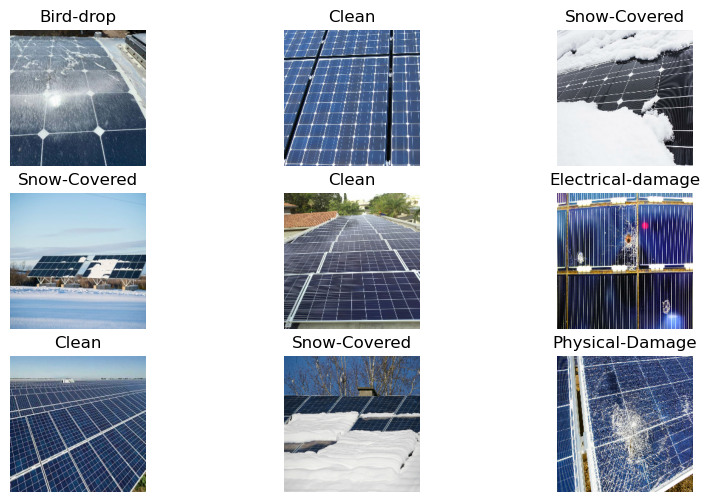

In [8]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
])


In [10]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_aug(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.2740 - loss: 1.9444 - val_accuracy: 0.4463 - val_loss: 1.3729
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 986ms/step - accuracy: 0.5127 - loss: 1.2842 - val_accuracy: 0.5706 - val_loss: 1.1255
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6158 - loss: 1.0250 - val_accuracy: 0.6158 - val_loss: 1.0216
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6681 - loss: 0.9357 - val_accuracy: 0.6271 - val_loss: 0.9525
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6879 - loss: 0.8383 - val_accuracy: 0.6441 - val_loss: 0.9480
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7218 - loss: 0.7938 - val_accuracy: 0.6554 - val_loss: 0.8767
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 922ms/step - accuracy: 0.7571 - loss: 0.6870 - val_accuracy: 0.6836 - val_loss: 0.8587
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 917ms/step - accuracy: 0.7669 - loss: 0.6443 - val_accuracy: 0.6836 - 

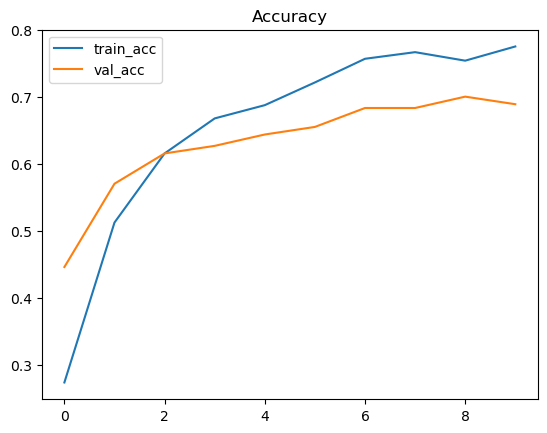

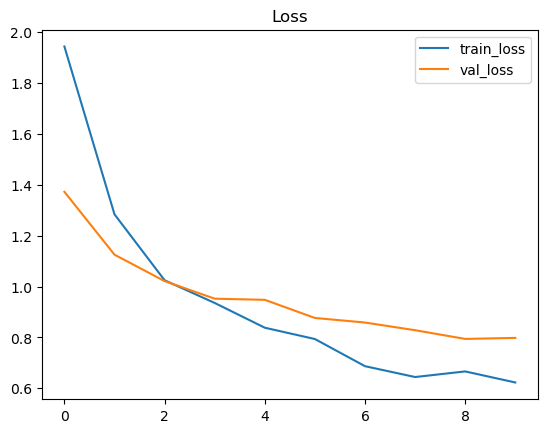

In [12]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


In [13]:
base.trainable = True

# fine-tune last 30 layers
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6017 - loss: 1.1639 - val_accuracy: 0.6667 - val_loss: 0.8563
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6398 - loss: 1.0441 - val_accuracy: 0.6215 - val_loss: 0.9445
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6667 - loss: 0.9375 - val_accuracy: 0.6102 - val_loss: 1.0097
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7006 - loss: 0.8508 - val_accuracy: 0.5932 - val_loss: 1.0853
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7373 - loss: 0.7876 - val_accuracy: 0.5932 - val_loss: 1.1385


In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions on validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(probs, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


                   precision    recall  f1-score   support

        Bird-drop       0.79      0.49      0.60        45
            Clean       0.35      1.00      0.52        34
            Dusty       0.95      0.44      0.60        43
Electrical-damage       0.67      0.38      0.48        16
  Physical-Damage       1.00      0.42      0.59        19
     Snow-Covered       1.00      0.80      0.89        20

         accuracy                           0.59       177
        macro avg       0.79      0.59      0.62       177
     weighted avg       0.78      0.59      0.61       177

Confusion Matrix:
 [[22 20  1  2  0  0]
 [ 0 34  0  0  0  0]
 [ 4 20 19  0  0  0]
 [ 2  8  0  6  0  0]
 [ 0 10  0  1  8  0]
 [ 0  4  0  0  0 16]]
